# **Exploring the Connection Between Open Spaces and Crime Rates in Boston Neighborhoods**
### Anmar Abdi & Owen Chappellet
---
---



**Data Cleaning:**

In [1]:
!pip install geopandas
#Needs: cleancrimedata.csv, cleanoffensecodes.csv, cleanspaces.csv, Police_Districts.geojson
from google.colab import files

uploaded = files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [3]:
!ls

sample_data


In [ ]:
#Combine crime rates data sets
crimes2015 = pd.read_csv('crime2015.csv')
crimes2016 = pd.read_csv('crime2016.csv')
crimes2017 = pd.read_csv('crime2017.csv')
crimes2018 = pd.read_csv('crime2018.csv')
crimes2019 = pd.read_csv('crime2019.csv')
crimes2020 = pd.read_csv('crime2020.csv')
crimes2021 = pd.read_csv('crime2021.csv')
crimes2022 = pd.read_csv('crime2022.csv')
crimes2023 = pd.read_csv('crimereports.csv')
combinedcrimes = pd.concat([crimes2015, crimes2016, crimes2017, crimes2018, crimes2019, crimes2020, crimes2021, crimes2022, crimes2023], ignore_index=True)
combinedcrimes

Check null:

In [ ]:
cleancrimes.isnull().sum()

NameError: ignored

In [ ]:
#Drop all columns not needed + the 4000 rows missing District (only 1.2% of total rows. Other locations values were missing as well)
cleancrimes = combinedcrimes.drop(columns=['OFFENSE_CODE_GROUP', 'REPORTING_AREA', 'UCR_PART', 'Lat', 'Long', 'REPORTING_AREA', 'Location', 'STREET']).dropna(subset=['DISTRICT'])
cleancrimes.head()

NameError: ignored

To download cleaned crimes:

In [ ]:
cleancrimes.to_csv('cleancrimedata.csv', index=False)

In [ ]:
files.download('cleancrimedata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
openspaces = pd.read_csv('openspaces.csv')
cleanopenspaces = openspaces.drop(columns=['OBJECTID', 'PROTECTION', 'TYPECODE', 'ADDRESS', 'OS_Own_Jur', 'OS_Mngmnt', 'POS', 'PA', 'GDB_GEOMATTR_DATA', 'ALT_NAME', 'AgncyJuris','OS_ID', 'GDB_GEOMATTR_DATA'])
cleanopenspaces

---

## Start here:

Aggregate crime data:

In [4]:
districts = {
    'D14': 'Allston-Brighton',
    'D4': 'South End',
    'A15': 'Charlestown',
    'A7': 'Eastie',
    'A1': 'Downtown',
    'C6': 'South Boston',
    'B2': 'Roxbury',
    'E13': 'Jamaica Plain',
    'C11': 'Dorchester',
    'B3': 'Mattapan',
    'E5': 'West Roxbury',
    'E18': 'Hyde Park'
}

In [5]:
cleancrimes = pd.read_csv('cleancrimedata.csv')

<ipython-input-5-bad0c01ee947>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cleancrimes = pd.read_csv('cleancrimedata.csv')


In [6]:
cleancrimes['DISTRICT'] = cleancrimes['DISTRICT'].replace(districts)
cleancrimes.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,I172040657,2629,HARASSMENT,Dorchester,NaN,2015-06-15 00:00:00,2015,6,Monday,0
1,I162013546,3201,PROPERTY - LOST,Mattapan,NaN,2015-06-15 00:00:00,2015,6,Monday,0
2,I152051083,3115,INVESTIGATE PERSON,Eastie,NaN,2015-06-15 00:00:00,2015,6,Monday,0
3,I152059178,2647,THREATS TO DO BODILY HARM,Dorchester,NaN,2015-06-15 00:00:00,2015,6,Monday,0
4,I152049897,3201,PROPERTY - LOST,Roxbury,NaN,2015-06-15 00:00:00,2015,6,Monday,0


In [7]:
cleancrimes = cleancrimes.rename(columns={'DISTRICT': 'Neighborhood'}).drop(columns='SHOOTING')
cleancrimes.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,Neighborhood,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,I172040657,2629,HARASSMENT,Dorchester,2015-06-15 00:00:00,2015,6,Monday,0
1,I162013546,3201,PROPERTY - LOST,Mattapan,2015-06-15 00:00:00,2015,6,Monday,0
2,I152051083,3115,INVESTIGATE PERSON,Eastie,2015-06-15 00:00:00,2015,6,Monday,0
3,I152059178,2647,THREATS TO DO BODILY HARM,Dorchester,2015-06-15 00:00:00,2015,6,Monday,0
4,I152049897,3201,PROPERTY - LOST,Roxbury,2015-06-15 00:00:00,2015,6,Monday,0


---

Use police district map to find Sq Miles of each neighborhood:

In [8]:
police_districts = gpd.read_file('Police_Districts.geojson')

In [9]:
#convert to Cordinate Reference System using most common projection coordinate system (epsg 3857)
police_districts = police_districts.to_crs(epsg=3857)

In [10]:
# 1 square meter = 3.86102e-7 square miles
police_districts['area_sqmi'] = police_districts['geometry'].area * 3.86102e-7
police_districts.head()

,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTArea,ShapeSTLength,geometry,area_sqmi
0,1,A15,A15,A,15,15,3.798284e+07,57556.859964,"MULTIPOLYGON (((-7911938.986 5219656.286, -791...",2.498531
1,2,A7,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-7903288.029 5220419.023, -790...",9.214521
2,3,A1,A1,A,1,01,4.445582e+07,49080.786370,"POLYGON ((-7909471.930 5216390.415, -7909494.0...",2.922369
3,4,C6,C6,C,6,06,1.236928e+08,93915.389108,"POLYGON ((-7908588.335 5214159.844, -7908582.0...",8.125166
4,5,D4,D4,D,4,04,7.000553e+07,41040.347429,"POLYGON ((-7911939.839 5214643.075, -7911961.1...",4.599903


In [11]:
#From https://statisticalatlas.com/place/Massachusetts/Boston/Population (hand counted)
populations = {'Neighborhood': ['Allston-Brighton', 'South End', 'Charlestown', 'Eastie', 'Downtown', 'South Boston', 'Roxbury', 'Jamaica Plain', 'Dorchester', 'Mattapan', 'West Roxbury', 'Hyde Park'],
               'Population': ['74794', '47076', '16439', '40508', '40358', '88354', '79654', '41262', '64024', '12753','58065', '66236']}
neighborhood_populations = pd.DataFrame(populations)
neighborhood_populations               

,Neighborhood,Population
0,Allston-Brighton,74794
1,South End,47076
2,Charlestown,16439
3,Eastie,40508
4,Downtown,40358
5,South Boston,88354
6,Roxbury,79654
7,Jamaica Plain,41262
8,Dorchester,64024
9,Mattapan,12753


In [12]:
districtsDf = pd.DataFrame(list(districts.items()), columns=['DISTRICT', 'Neighborhood'])

district_neighborhood_mapping = dict(zip(districtsDf['DISTRICT'], districtsDf['Neighborhood']))

police_districts['Neighborhood'] = police_districts['DISTRICT'].map(district_neighborhood_mapping)
police_districts.head()


,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTArea,ShapeSTLength,geometry,area_sqmi,Neighborhood
0,1,A15,A15,A,15,15,3.798284e+07,57556.859964,"MULTIPOLYGON (((-7911938.986 5219656.286, -791...",2.498531,Charlestown
1,2,A7,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((-7903288.029 5220419.023, -790...",9.214521,Eastie
2,3,A1,A1,A,1,01,4.445582e+07,49080.786370,"POLYGON ((-7909471.930 5216390.415, -7909494.0...",2.922369,Downtown
3,4,C6,C6,C,6,06,1.236928e+08,93915.389108,"POLYGON ((-7908588.335 5214159.844, -7908582.0...",8.125166,South Boston
4,5,D4,D4,D,4,04,7.000553e+07,41040.347429,"POLYGON ((-7911939.839 5214643.075, -7911961.1...",4.599903,South End


**Neighborhoods, their Population, and Area:**

In [13]:
# Merge Populations into police districts df
merged_data = neighborhood_populations.merge(police_districts[['Neighborhood', 'area_sqmi']], on='Neighborhood')
print(merged_data)


        Neighborhood Population  area_sqmi
0   Allston-Brighton      74794   8.125123
1          South End      47076   4.599903
2        Charlestown      16439   2.498531
3             Eastie      40508   9.214521
4           Downtown      40358   2.922369
5       South Boston      88354   8.125166
6            Roxbury      79654   7.850859
7      Jamaica Plain      41262   7.354018
8         Dorchester      64024   8.721692
9           Mattapan      12753   6.109534
10      West Roxbury      58065  12.530058
11         Hyde Park      66236  10.700546


In [17]:
merged_crime_data = merged_data.merge(cleancrimes, on='Neighborhood')
merged_crime_data

,Neighborhood,Population,area_sqmi,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,Allston-Brighton,74794,8.125123,I152049469,802,ASSAULT SIMPLE - BATTERY,2015-06-15 00:45:00,2015,6,Monday,0
1,Allston-Brighton,74794,8.125123,I152049479,802,ASSAULT SIMPLE - BATTERY,2015-06-15 01:30:00,2015,6,Monday,1
2,Allston-Brighton,74794,8.125123,I152049483,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 02:00:00,2015,6,Monday,2
3,Allston-Brighton,74794,8.125123,I152050209,3201,PROPERTY - LOST,2015-06-15 03:00:00,2015,6,Monday,3
4,Allston-Brighton,74794,8.125123,I152050200,1106,FRAUD - CREDIT CARD / ATM FRAUD,2015-06-15 07:00:00,2015,6,Monday,7
...,...,...,...,...,...,...,...,...,...,...,...
673678,Hyde Park,66236,10.700546,232030338,1831,SICK ASSIST,2023-04-19 17:00:00+00,2023,4,Wednesday,17
673679,Hyde Park,66236,10.700546,232030386,3801,M/V ACCIDENT - OTHER,2023-04-19 19:34:00+00,2023,4,Wednesday,19
673680,Hyde Park,66236,10.700546,232030397,3115,INVESTIGATE PERSON,2023-04-19 20:00:00+00,2023,4,Wednesday,20
673681,Hyde Park,66236,10.700546,232030429,3115,INVESTIGATE PERSON,2023-04-19 22:27:00+00,2023,4,Wednesday,22


In [15]:
# manually cleaned offense codes data set to only include crimes which present a danger to the community (violent/property/drug crimes)
offensecodes = pd.read_csv('cleanoffensecodes.csv')
offensecodesDf = pd.DataFrame(offensecodes)
offensecodesDf = offensecodesDf.dropna()
offensecodesDf['CODE'] = offensecodesDf['CODE'].astype(int)
offensecodesDf

,CODE,NAME
0,111,MURDER NON-NEGLIGIENT MANSLAUGHTER
1,112,KILLING OF FELON BY POLICE
2,113,KILLING OF FELON BY CITIZEN
3,114,KILLING OF POLICE BY FELON
4,121,MANSLAUGHTER - VEHICLE - NEGLIGENCE
...,...,...
254,3022,DRUGS - SICK ASSIST - OTHER NARCOTICS
255,3023,DRUGS - SICK ASSIST - HARMFUL DRUG
256,3119,FIREARM/WEAPON - FOUND OR CONFISCATED
257,3501,MISSING PERSON


In [16]:
#filter relevant crimes by offensecode
filteredcrimes = merged_crime_data[merged_crime_data['OFFENSE_CODE'].isin(offensecodesDf['CODE'])]
filteredcrimes

,Neighborhood,Population,area_sqmi,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR
0,Allston-Brighton,74794,8.125123,I152049469,802,ASSAULT SIMPLE - BATTERY,2015-06-15 00:45:00,2015,6,Monday,0
1,Allston-Brighton,74794,8.125123,I152049479,802,ASSAULT SIMPLE - BATTERY,2015-06-15 01:30:00,2015,6,Monday,1
2,Allston-Brighton,74794,8.125123,I152049483,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 02:00:00,2015,6,Monday,2
5,Allston-Brighton,74794,8.125123,I152049577,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 09:01:00,2015,6,Monday,9
11,Allston-Brighton,74794,8.125123,I152050600,617,LARCENY THEFT FROM BUILDING,2015-06-15 19:00:00,2015,6,Monday,19
...,...,...,...,...,...,...,...,...,...,...,...
673674,Hyde Park,66236,10.700546,232030273,1832,SICK ASSIST - DRUG RELATED ILLNESS,2023-04-19 13:08:00+00,2023,4,Wednesday,13
673675,Hyde Park,66236,10.700546,232030281,2647,THREATS TO DO BODILY HARM,2023-04-19 13:30:00+00,2023,4,Wednesday,13
673677,Hyde Park,66236,10.700546,232030368,619,LARCENY ALL OTHERS,2023-04-19 16:38:00+00,2023,4,Wednesday,16
673678,Hyde Park,66236,10.700546,232030338,1831,SICK ASSIST,2023-04-19 17:00:00+00,2023,4,Wednesday,17


In [18]:
crime_count = filteredcrimes.groupby('Neighborhood').size().reset_index(name='Crime_Count')
crime_count

,Neighborhood,Crime_Count
0,Allston-Brighton,16567
1,Charlestown,5361
2,Dorchester,34344
3,Downtown,33326
4,Eastie,11480
5,Hyde Park,12645
6,Jamaica Plain,14673
7,Mattapan,27515
8,Roxbury,40075
9,South Boston,21646


In [19]:
merged_data_with_crime = merged_data.merge(crime_count, on='Neighborhood')
merged_data_with_crime.head()

,Neighborhood,Population,area_sqmi,Crime_Count
0,Allston-Brighton,74794,8.125123,16567
1,South End,47076,4.599903,41291
2,Charlestown,16439,2.498531,5361
3,Eastie,40508,9.214521,11480
4,Downtown,40358,2.922369,33326


In [20]:
merged_data_with_crime['Crime_Per_SqMile'] = merged_data_with_crime['Crime_Count'] / merged_data_with_crime['area_sqmi']

# Change Population column from str to numbers
merged_data_with_crime['Population'] = pd.to_numeric(merged_data_with_crime['Population'])

# Calculating crime per capita considering the square mile area
merged_data_with_crime['Crime_Rate_Per_Capita'] = merged_data_with_crime['Crime_Per_SqMile'] / merged_data_with_crime['Population']
merged_data_with_crime

,Neighborhood,Population,area_sqmi,Crime_Count,Crime_Per_SqMile,Crime_Rate_Per_Capita
0,Allston-Brighton,74794,8.125123,16567,2038.984533,0.027261
1,South End,47076,4.599903,41291,8976.494123,0.190681
2,Charlestown,16439,2.498531,5361,2145.660440,0.130523
3,Eastie,40508,9.214521,11480,1245.859664,0.030756
4,Downtown,40358,2.922369,33326,11403.760751,0.282565
5,South Boston,88354,8.125166,21646,2664.068543,0.030152
6,Roxbury,79654,7.850859,40075,5104.536866,0.064084
7,Jamaica Plain,41262,7.354018,14673,1995.235894,0.048355
8,Dorchester,64024,8.721692,34344,3937.768216,0.061505
9,Mattapan,12753,6.109534,27515,4503.616696,0.353142


In [25]:
offense_code_counts = cleancrimes['OFFENSE_CODE'].value_counts()

# Top 10 most common offense codes and their counts (interesting 🧐 )
top_10_offense_codes = offense_code_counts.head(10)

print("Top 10 most common offense codes and their counts:")
print(top_10_offense_codes)


Top 10 most common offense codes and their counts:
3115    48700
3831    36556
3006    32993
1402    30280
3114    27124
3410    25273
3301    23489
802     20211
3201    19758
614     18845
Name: OFFENSE_CODE, dtype: int64


In [21]:
openspaces = pd.read_csv('cleanspaces.csv')
openspaces = openspaces[openspaces['DISTRICT'] != 'Multi-District']

In [22]:
district_renaming = {
    'Roslindale': 'West Roxbury',
    'Central Boston': 'Downtown',
    'Mission Hill': 'Roxbury',
    'Fenway/Longwood': 'South End',
    'Back Bay/Beacon Hill': 'South End',
    'East Boston': 'Eastie'
}

In [23]:
#Rename some districts to match police district map
openspaces['DISTRICT'] = openspaces['DISTRICT'].replace(district_renaming)
openspaces

,SITE_NAME,OWNERSHIP,DISTRICT,ACRES,TypeLong
0,Wilson Park,City of Boston,Allston-Brighton,0.097184,"Malls, Squares & Plazas"
1,James H. Roberts Playground,City of Boston,Allston-Brighton,1.004136,"Parks, Playgrounds & Athletic Fields"
2,Smith Playground,City of Boston,Allston-Brighton,15.025247,"Parks, Playgrounds & Athletic Fields"
3,Fern Square,City of Boston,Allston-Brighton,0.044509,"Malls, Squares & Plazas"
4,Ringer Playground,City of Boston,Allston-Brighton,10.263093,"Parks, Playgrounds & Athletic Fields"
...,...,...,...,...,...
479,Paula Titus Park,City of Boston,Roxbury,0.182374,"Parks, Playgrounds & Athletic Fields"
480,Watson Park,City of Boston,South End,0.106896,"Parks, Playgrounds & Athletic Fields"
481,Nonquit Street Green,City of Boston,Dorchester,0.340466,"Parks, Playgrounds & Athletic Fields"
482,Mahoney Park,City of Boston,South Boston,0.381102,"Parks, Playgrounds & Athletic Fields"


In [24]:
# Remove Cemetaries and Harbor Island open spaces
cleanspaces = openspaces.drop(openspaces[(openspaces['TypeLong'] == 'Cemeteries & Burying Grounds') | (openspaces['DISTRICT'] == 'Harbor Islands')].index)
# cleanspaces = cleanspaces.drop(columns=['ZonAgg', 'REGION'])
cleanspaces

,SITE_NAME,OWNERSHIP,DISTRICT,ACRES,TypeLong
0,Wilson Park,City of Boston,Allston-Brighton,0.097184,"Malls, Squares & Plazas"
1,James H. Roberts Playground,City of Boston,Allston-Brighton,1.004136,"Parks, Playgrounds & Athletic Fields"
2,Smith Playground,City of Boston,Allston-Brighton,15.025247,"Parks, Playgrounds & Athletic Fields"
3,Fern Square,City of Boston,Allston-Brighton,0.044509,"Malls, Squares & Plazas"
4,Ringer Playground,City of Boston,Allston-Brighton,10.263093,"Parks, Playgrounds & Athletic Fields"
...,...,...,...,...,...
479,Paula Titus Park,City of Boston,Roxbury,0.182374,"Parks, Playgrounds & Athletic Fields"
480,Watson Park,City of Boston,South End,0.106896,"Parks, Playgrounds & Athletic Fields"
481,Nonquit Street Green,City of Boston,Dorchester,0.340466,"Parks, Playgrounds & Athletic Fields"
482,Mahoney Park,City of Boston,South Boston,0.381102,"Parks, Playgrounds & Athletic Fields"


In [ ]:
cleanspaces.to_csv('cleanspaces.csv', index=False)
files.download('cleanspaces.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
openspacescount = cleanspaces.groupby('DISTRICT').size().reset_index(name='Count').sort_values(by='Count', ascending=False).rename(columns={'DISTRICT': 'Neighborhood'})
openspacescount

,Neighborhood,Count
8,Roxbury,58
2,Dorchester,57
3,Downtown,53
10,South End,50
11,West Roxbury,44
5,Hyde Park,38
0,Allston-Brighton,37
6,Jamaica Plain,35
4,Eastie,32
9,South Boston,32


In [26]:
# Sum acres of each neighborhood's open spaces
openspacearea = openspaces.groupby('DISTRICT')['ACRES'].sum().reset_index()
openspacearea.columns = ['Neighborhood', 'Open_Space_Acres']
open_space_sum = openspacearea.merge(openspacescount, on='Neighborhood')
open_space_sum


,Neighborhood,Open_Space_Acres,Count
0,Allston-Brighton,226.383840,37
1,Charlestown,61.282307,24
2,Dorchester,234.895242,57
3,Downtown,122.157767,53
4,Eastie,249.902139,32
5,Hyde Park,690.564868,38
6,Jamaica Plain,496.186278,35
7,Mattapan,189.621393,24
8,Roxbury,597.269216,58
9,South Boston,244.714766,32


In [27]:
# Merge crime with open space area + count
CrimeOpenSpaceDf = pd.merge(merged_data_with_crime, openspacearea, on='Neighborhood')
CrimeOpenSpaceDf

,Neighborhood,Population,area_sqmi,Crime_Count,Crime_Per_SqMile,Crime_Rate_Per_Capita,Open_Space_Acres
0,Allston-Brighton,74794,8.125123,16567,2038.984533,0.027261,226.383840
1,South End,47076,4.599903,41291,8976.494123,0.190681,150.424201
2,Charlestown,16439,2.498531,5361,2145.660440,0.130523,61.282307
3,Eastie,40508,9.214521,11480,1245.859664,0.030756,249.902139
4,Downtown,40358,2.922369,33326,11403.760751,0.282565,122.157767
5,South Boston,88354,8.125166,21646,2664.068543,0.030152,244.714766
6,Roxbury,79654,7.850859,40075,5104.536866,0.064084,597.269216
7,Jamaica Plain,41262,7.354018,14673,1995.235894,0.048355,496.186278
8,Dorchester,64024,8.721692,34344,3937.768216,0.061505,234.895242
9,Mattapan,12753,6.109534,27515,4503.616696,0.353142,189.621393


In [28]:
day_of_week_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

def get_day_of_year(year, month, day_of_week):
    day_of_week_numeric = day_of_week_mapping[day_of_week]
    return pd.Timestamp(year=year, month=month, day=1).dayofyear + day_of_week_numeric - 1

filteredcrimes['Day_of_Year'] = filteredcrimes.apply(lambda row: get_day_of_year(row['YEAR'], row['MONTH'], row['DAY_OF_WEEK']), axis=1)
filteredcrimes

,Neighborhood,Population,area_sqmi,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Day_of_Year
0,Allston-Brighton,74794,8.125123,I152049469,802,ASSAULT SIMPLE - BATTERY,2015-06-15 00:45:00,2015,6,Monday,0,152
1,Allston-Brighton,74794,8.125123,I152049479,802,ASSAULT SIMPLE - BATTERY,2015-06-15 01:30:00,2015,6,Monday,1,152
2,Allston-Brighton,74794,8.125123,I152049483,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 02:00:00,2015,6,Monday,2,152
5,Allston-Brighton,74794,8.125123,I152049577,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 09:01:00,2015,6,Monday,9,152
11,Allston-Brighton,74794,8.125123,I152050600,617,LARCENY THEFT FROM BUILDING,2015-06-15 19:00:00,2015,6,Monday,19,152
...,...,...,...,...,...,...,...,...,...,...,...,...
673674,Hyde Park,66236,10.700546,232030273,1832,SICK ASSIST - DRUG RELATED ILLNESS,2023-04-19 13:08:00+00,2023,4,Wednesday,13,93
673675,Hyde Park,66236,10.700546,232030281,2647,THREATS TO DO BODILY HARM,2023-04-19 13:30:00+00,2023,4,Wednesday,13,93
673677,Hyde Park,66236,10.700546,232030368,619,LARCENY ALL OTHERS,2023-04-19 16:38:00+00,2023,4,Wednesday,16,93
673678,Hyde Park,66236,10.700546,232030338,1831,SICK ASSIST,2023-04-19 17:00:00+00,2023,4,Wednesday,17,93


In [29]:
crime_with_open_space = filteredcrimes.merge(open_space_sum, on='Neighborhood', how='left')
crime_with_open_space

,Neighborhood,Population,area_sqmi,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Day_of_Year,Open_Space_Acres,Count
0,Allston-Brighton,74794,8.125123,I152049469,802,ASSAULT SIMPLE - BATTERY,2015-06-15 00:45:00,2015,6,Monday,0,152,226.383840,37
1,Allston-Brighton,74794,8.125123,I152049479,802,ASSAULT SIMPLE - BATTERY,2015-06-15 01:30:00,2015,6,Monday,1,152,226.383840,37
2,Allston-Brighton,74794,8.125123,I152049483,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 02:00:00,2015,6,Monday,2,152,226.383840,37
3,Allston-Brighton,74794,8.125123,I152049577,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 09:01:00,2015,6,Monday,9,152,226.383840,37
4,Allston-Brighton,74794,8.125123,I152050600,617,LARCENY THEFT FROM BUILDING,2015-06-15 19:00:00,2015,6,Monday,19,152,226.383840,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269088,Hyde Park,66236,10.700546,232030273,1832,SICK ASSIST - DRUG RELATED ILLNESS,2023-04-19 13:08:00+00,2023,4,Wednesday,13,93,690.564868,38
269089,Hyde Park,66236,10.700546,232030281,2647,THREATS TO DO BODILY HARM,2023-04-19 13:30:00+00,2023,4,Wednesday,13,93,690.564868,38
269090,Hyde Park,66236,10.700546,232030368,619,LARCENY ALL OTHERS,2023-04-19 16:38:00+00,2023,4,Wednesday,16,93,690.564868,38
269091,Hyde Park,66236,10.700546,232030338,1831,SICK ASSIST,2023-04-19 17:00:00+00,2023,4,Wednesday,17,93,690.564868,38


In [30]:
crime_with_open_space['Population'] = crime_with_open_space['Population'].astype(str).astype(int)

In [142]:
crime_with_open_space['Population_Density'] = crime_with_open_space['Population'] / crime_with_open_space['area_sqmi']
crime_with_open_space['Open_Space_Percentage'] = (crime_with_open_space['Open_Space_Acres'] / (crime_with_open_space['area_sqmi'] * 640)) * 100
crime_with_open_space

,Neighborhood,Population,area_sqmi,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Day_of_Year,Open_Space_Acres,Count,Population_Density,Open_Space_Proportion,Open_Space_Percentage
0,Allston-Brighton,74794,8.125123,I152049469,802,ASSAULT SIMPLE - BATTERY,2015-06-15 00:45:00,2015,6,Monday,0,152,226.383840,37,9205.276101,4.353470,4.353470
1,Allston-Brighton,74794,8.125123,I152049479,802,ASSAULT SIMPLE - BATTERY,2015-06-15 01:30:00,2015,6,Monday,1,152,226.383840,37,9205.276101,4.353470,4.353470
2,Allston-Brighton,74794,8.125123,I152049483,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 02:00:00,2015,6,Monday,2,152,226.383840,37,9205.276101,4.353470,4.353470
3,Allston-Brighton,74794,8.125123,I152049577,413,ASSAULT - AGGRAVATED - BATTERY,2015-06-15 09:01:00,2015,6,Monday,9,152,226.383840,37,9205.276101,4.353470,4.353470
4,Allston-Brighton,74794,8.125123,I152050600,617,LARCENY THEFT FROM BUILDING,2015-06-15 19:00:00,2015,6,Monday,19,152,226.383840,37,9205.276101,4.353470,4.353470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269088,Hyde Park,66236,10.700546,232030273,1832,SICK ASSIST - DRUG RELATED ILLNESS,2023-04-19 13:08:00+00,2023,4,Wednesday,13,93,690.564868,38,6189.964457,10.083669,10.083669
269089,Hyde Park,66236,10.700546,232030281,2647,THREATS TO DO BODILY HARM,2023-04-19 13:30:00+00,2023,4,Wednesday,13,93,690.564868,38,6189.964457,10.083669,10.083669
269090,Hyde Park,66236,10.700546,232030368,619,LARCENY ALL OTHERS,2023-04-19 16:38:00+00,2023,4,Wednesday,16,93,690.564868,38,6189.964457,10.083669,10.083669
269091,Hyde Park,66236,10.700546,232030338,1831,SICK ASSIST,2023-04-19 17:00:00+00,2023,4,Wednesday,17,93,690.564868,38,6189.964457,10.083669,10.083669


In [143]:
daily_crime_df = crime_with_open_space.groupby(['Neighborhood', 'YEAR', 'MONTH', 'Day_of_Year']).agg({
    'OFFENSE_CODE': 'count',
    'Population': 'mean',
    'Population_Density': 'mean',
    'Open_Space_Percentage': 'mean'
}).reset_index()

daily_crime_df['Crime_Rate'] = daily_crime_df['OFFENSE_CODE'] / daily_crime_df['Population']
daily_crime_df

,Neighborhood,YEAR,MONTH,Day_of_Year,OFFENSE_CODE,Population,Population_Density,Open_Space_Percentage,Crime_Rate
0,Allston-Brighton,2015,6,152,16,74794.0,9205.276101,4.353470,0.000214
1,Allston-Brighton,2015,6,153,19,74794.0,9205.276101,4.353470,0.000254
2,Allston-Brighton,2015,6,154,16,74794.0,9205.276101,4.353470,0.000214
3,Allston-Brighton,2015,6,155,15,74794.0,9205.276101,4.353470,0.000201
4,Allston-Brighton,2015,6,156,16,74794.0,9205.276101,4.353470,0.000214
...,...,...,...,...,...,...,...,...,...
7974,West Roxbury,2023,4,93,5,58065.0,4634.056707,8.860555,0.000086
7975,West Roxbury,2023,4,94,5,58065.0,4634.056707,8.860555,0.000086
7976,West Roxbury,2023,4,95,3,58065.0,4634.056707,8.860555,0.000052
7977,West Roxbury,2023,4,96,6,58065.0,4634.056707,8.860555,0.000103


In [145]:
neighborhood_open_space = daily_crime_df.groupby('Neighborhood')['Open_Space_Percentage'].mean().reset_index()
neighborhood_open_space = neighborhood_open_space.sort_values(by='Open_Space_Percentage', ascending=True)
neighborhood_open_space
#good cut off would be 7% (in between 3 and 11)

,Neighborhood,Open_Space_Percentage
1,Charlestown,3.832395
2,Dorchester,4.208172
4,Eastie,4.237573
0,Allston-Brighton,4.353470
9,South Boston,4.705957
7,Mattapan,4.849526
10,South End,5.109626
3,Downtown,6.531396
11,West Roxbury,8.860555
5,Hyde Park,10.083669


In [146]:
# Split into testing and training
train_df = daily_crime_df[(daily_crime_df['YEAR'] >= 2015) & (daily_crime_df['YEAR'] <= 2022)]
test_df = daily_crime_df[daily_crime_df['YEAR'] == 2023]

In [68]:
crime_with_open_space.dtypes

Neighborhood            object
Population               int64
area_sqmi              float64
INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_DESCRIPTION     object
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
Day_of_Year              int64
Open_Space_Acres       float64
Count                  float64
dtype: object

In [149]:
high_open_space = daily_crime_df[daily_crime_df['Open_Space_Percentage'] > 7]
low_open_space = daily_crime_df[daily_crime_df['Open_Space_Percentage'] <= 7]

high_open_space_avg_crime_rate = high_open_space['Crime_Rate'].mean()
low_open_space_avg_crime_rate = low_open_space['Crime_Rate'].mean()

if high_open_space_avg_crime_rate < low_open_space_avg_crime_rate:
    print("Neighborhoods with an open space percentage greater than 7% have a lower crime rate.")
else:
    print("Neighborhoods with an open space percentage lower than 7% have a lower crime rate.")

Neighborhoods with an open space percentage greater than 7% have a lower crime rate.


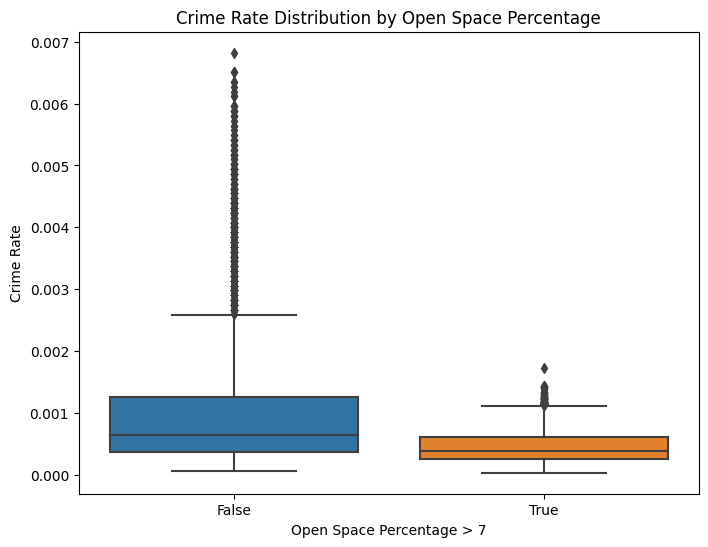

In [151]:
daily_crime_df['High_Open_Space'] = daily_crime_df['Open_Space_Percentage'] > 7

plt.figure(figsize=(8, 6))
sns.boxplot(x='High_Open_Space', y='Crime_Rate', data=daily_crime_df)
plt.xlabel('Open Space Percentage > 7')
plt.ylabel('Crime Rate')
plt.title('Crime Rate Distribution by Open Space Percentage')

plt.show()


<ipython-input-153-ea9bd22b34b2>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='High_Open_Space', y='Crime_Rate', data=daily_crime_df, ci=None)


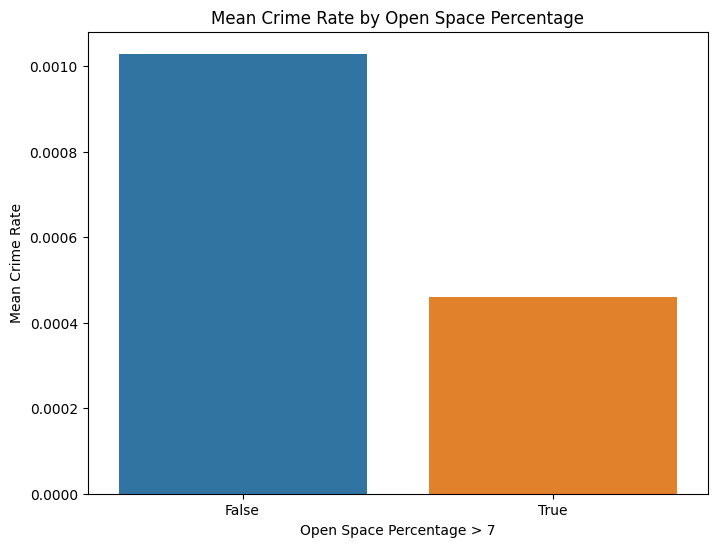

In [153]:
plt.figure(figsize=(8, 6))
sns.barplot(x='High_Open_Space', y='Crime_Rate', data=daily_crime_df, ci=None)
plt.xlabel('Open Space Percentage > 7')
plt.ylabel('Mean Crime Rate')
plt.title('Mean Crime Rate by Open Space Percentage')

plt.show()


<ipython-input-166-169469cd2adb>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Open_Space_Category', y='Crime_Rate', data=daily_crime_df, ci=None)


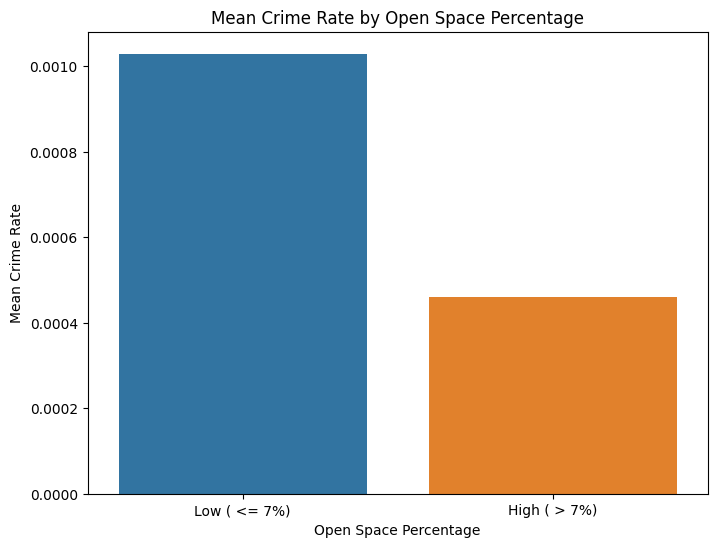

In [166]:
daily_crime_df['Open_Space_Category'] = daily_crime_df['High_Open_Space'].apply(lambda x: 'High ( > 7%)' if x else 'Low ( <= 7%)')
plt.figure(figsize=(8, 6))
sns.barplot(x='Open_Space_Category', y='Crime_Rate', data=daily_crime_df, ci=None)
plt.xlabel('Open Space Percentage')
plt.ylabel('Mean Crime Rate')
plt.title('Mean Crime Rate by Open Space Percentage')
plt.show()


---

# Models

---

In [38]:
# Decision Tree 🌲  (BAD)
from sklearn.model_selection import train_test_split

X = CrimeOpenSpaceDf[['Open_Space_Acres', 'Count']]
y = CrimeOpenSpaceDf['Crime_Rate_Per_Capita']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TreeModel = DecisionTreeRegressor(random_state=42)
TreeModel.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [40]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = TreeModel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree")
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Decision Tree
Mean Squared Error: 0.0011086413159490398
R-squared: -1.4679675468005624


In [41]:
# Random forest 🌳 (BAD)
X = CrimeOpenSpaceDf[['Population', 'area_sqmi', 'Open_Space_Acres', 'Count']]
y = CrimeOpenSpaceDf['Crime_Rate_Per_Capita']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)
y_pred

array([0.05178799, 0.04203801, 0.03887014])

In [44]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2) #bad

Mean Squared Error: 0.0003297146915336433
R-squared: 0.2660158459710572


---

In [155]:
# Good Random Forest Model!!!
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
X = train_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y = train_df['Crime_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model (Test Data: 2015-2022):")
print(f"Mean Aabsolute Error: {mae_rf}")
print(f"Mean Sq. Error: {mse_rf}")
print(f"Root MSE: {rmse_rf}")
print(f"R2 score: {r2_rf}")

Random Forest Model (Test Data: 2015-2022):
Mean Aabsolute Error: 0.00023708926000062789
Mean Sq. Error: 1.6783742373668885e-07
Root MSE: 0.00040967965990110965
R2 score: 0.8051928863768013


In [156]:
X_test_2023 = test_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y_test_2023 = test_df['Crime_Rate']

y_pred_rf_2023 = rf_model.predict(X_test_2023)

mae_rf_2023 = mean_absolute_error(y_test_2023, y_pred_rf_2023)
mse_rf_2023 = mean_squared_error(y_test_2023, y_pred_rf_2023)
rmse_rf_2023 = np.sqrt(mse_rf_2023)
r2_rf_2023 = r2_score(y_test_2023, y_pred_rf_2023)

print("Random Forest Model (2023 data):")
print(f"Mean Aabsolute Error: {mae_rf_2023}")
print(f"Mean Sq. Error: {mse_rf_2023}")
print(f"Root MSE: {rmse_rf_2023}")
print(f"R2 score: {r2_rf_2023}")

Random Forest Model (2023 data):
Mean Aabsolute Error: 0.00023378971962957095
Mean Sq. Error: 1.4370444128302654e-07
Root MSE: 0.0003790836863847171
R2 score: 0.7032684970787804


[0.00026479 0.00026479 0.00123444 ... 0.0004987  0.0007724  0.00026479]


<function matplotlib.pyplot.show(close=None, block=None)>

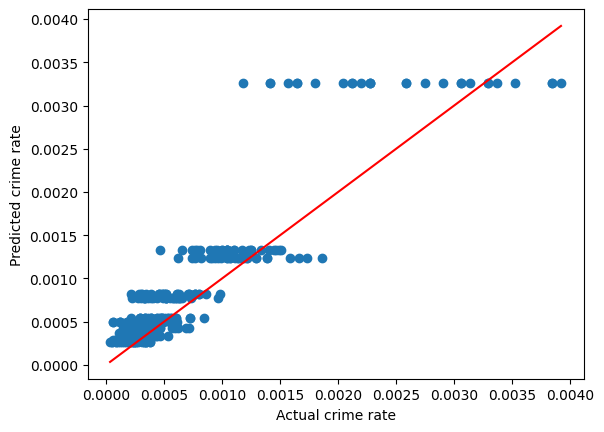

In [157]:
print(y_pred_rf)
plt.scatter(y_test_2023, y_pred_rf_2023)
plt.xlabel('Actual crime rate')
plt.ylabel('Predicted crime rate')
plt.plot([min(y_test_2023), max(y_test_2023)], [min(y_test_2023), max(y_test_2023)], color='red')
plt.show

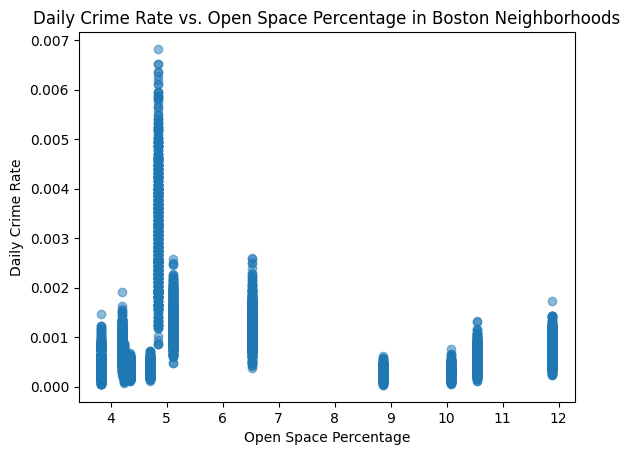

In [158]:
plt.scatter(daily_crime_df['Open_Space_Percentage'], daily_crime_df['Crime_Rate'], alpha=0.5)

plt.xlabel('Open Space Percentage')
plt.ylabel('Daily Crime Rate')

plt.title('Daily Crime Rate vs. Open Space Percentage in Boston Neighborhoods')
plt.show()

---

In [161]:
# Decision Tree model
X_train = train_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y_train = train_df['Crime_Rate']

X_test = test_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y_test = test_df['Crime_Rate']

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

y_pred_dt = tree_model.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Model:")
print(f"Mean Aabsolute Error: {mae_dt}")
print(f"Mean Sq. Error: {mse_dt}")
print(f"Root MSE: {rmse_dt}")
print(f"R2 score: {r2_dt}")

Decision Tree Model:
Mean Aabsolute Error: 0.00023459525671057553
Mean Sq. Error: 1.4568959096425738e-07
Root MSE: 0.0003816930585748939
R2 score: 0.6991694139664146


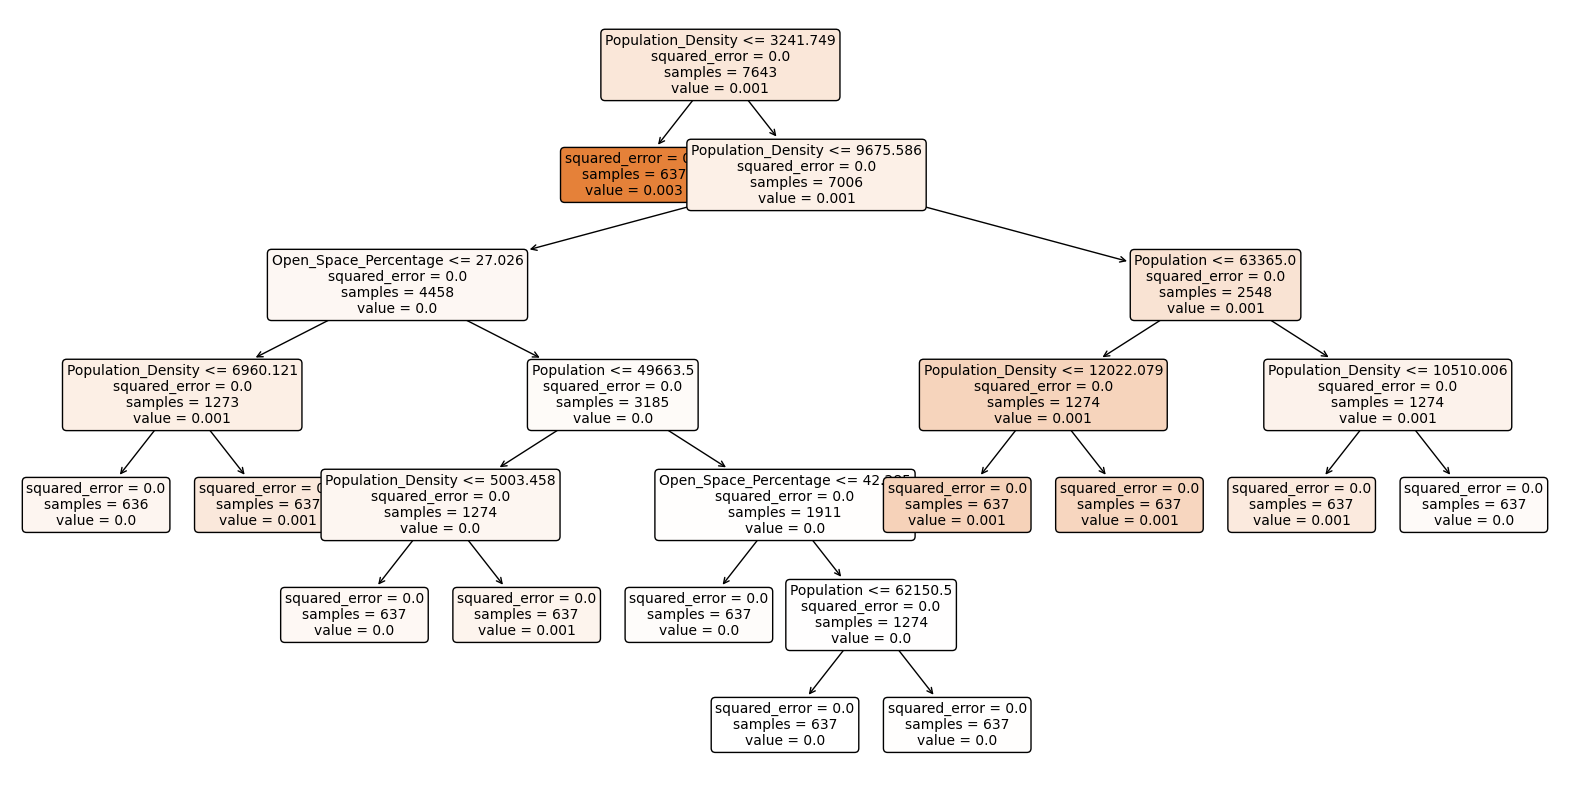

In [162]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Crime_Rate'], rounded=True, fontsize=10)
plt.show()


---

In [163]:
#KNearest
X_train = train_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y_train = train_df['Crime_Rate']

X_test = test_df[['Population', 'Population_Density', 'Open_Space_Percentage']]
y_test = test_df['Crime_Rate']

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("K-Nearest Neighbors Model:")
print(f"Mean Aabsolute Error: {mae_knn}")
print(f"Mean Sq. Error: {mse_knn}")
print(f"Root MSE: {rmse_knn}")
print(f"R2 score: {r2_knn}")


K-Nearest Neighbors Model:
Mean Aabsolute Error: 0.00020137684844302446
Mean Sq. Error: 9.417272162163432e-08
Root MSE: 0.00030687574296714025
R2 score: 0.8055452359615434


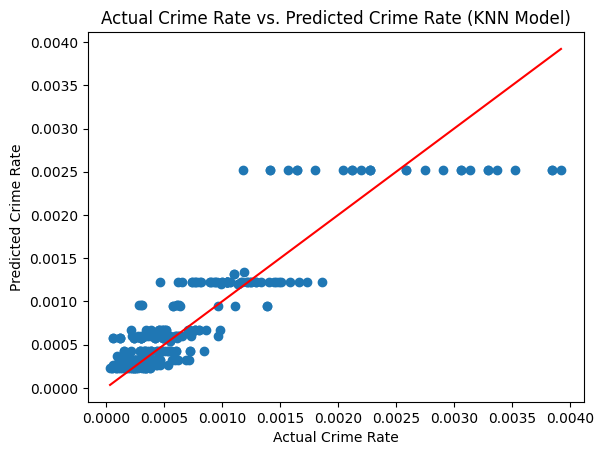

In [164]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_knn)
plt.xlabel("Actual Crime Rate")
plt.ylabel("Predicted Crime Rate")
plt.title("Actual Crime Rate vs. Predicted Crime Rate (KNN Model)")

# line = perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()